In [3]:
!pip3 install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.3 MB/s eta 0:00:00


In [98]:
import warnings
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import RGATConv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from google.colab import drive

warnings.filterwarnings("ignore")

pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.max_columns", None)
pd.set_option("display.min_rows", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("display.width", None)

sns.set_theme(style="whitegrid")

drive_path = "/content/drive"
drive.mount(drive_path)
base_path = f"{drive_path}/My Drive/Colab Notebooks/gnn/input"
data_path = f"{base_path}/march-machine-learning-mania-2025"
gnn_path = f"{base_path}/gnn"

device = "cuda" if torch.cuda.is_available() else "cpu"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
def load_nodes(asc_or_des):
  nodes = pd.read_csv(f"{gnn_path}/nodes_{asc_or_des}.csv")
  nodes["Date"] = pd.to_datetime(nodes["Date"])

  nodes = pd.concat([
      nodes[["Index"]].astype("int32"),
      nodes[["Key"]],
      nodes[["Season"]].astype("int32"),
      nodes[["Date"]],
      nodes[["Le_TeamID", "Ri_TeamID"]].astype("int32"),
      nodes[["Le_TeamName", "Ri_TeamName"]],
      nodes.loc[:, "Le_Margin":].astype("int32"),
    ],
    axis=1,
  )

  nodes.index = nodes.index.astype("int32")

  return nodes

In [10]:
nodes_asc = load_nodes("asc")

print(f"nodes_asc {nodes_asc.shape}")
print(nodes_asc)
print()
nodes_asc.info()

nodes_asc (202866, 43)
         Index                 Key  Season       Date  Le_TeamID  Ri_TeamID      Le_TeamName      Ri_TeamName  Le_Margin  SeasonsAgo  Men  NCAATourney  DayNum  NumOT  Le_Loc  Le_Score  Le_FGM  Le_FGA  Le_FGM3  Le_FGA3  Le_FTM  Le_FTA  Le_OR  Le_DR  Le_Ast  Le_TO  Le_Stl  Le_Blk  Le_PF  Ri_Score  Ri_FGM  Ri_FGA  Ri_FGM3  Ri_FGA3  Ri_FTM  Ri_FTA  Ri_OR  Ri_DR  Ri_Ast  Ri_TO  Ri_Stl  Ri_Blk  Ri_PF
0            0  2003_010_1104_1328    2003 2002-11-14       1104       1328          Alabama         Oklahoma          6          22    1            0      10      0       0        68      27      58        3       14      11      18     14     24      13     23       7       1     22        62      22      53        2       10      16      22     10     22       8     18       9       2     20
1            1  2003_010_1272_1393    2003 2002-11-14       1272       1393          Memphis         Syracuse          7          22    1            0      10      0       0        

In [11]:
nodes_des = load_nodes("des")

print(f"nodes_des {nodes_des.shape}")
print(nodes_des)
print()
nodes_des.info()

nodes_des (202866, 43)
         Index                 Key  Season       Date  Le_TeamID  Ri_TeamID      Le_TeamName      Ri_TeamName  Le_Margin  SeasonsAgo  Men  NCAATourney  DayNum  NumOT  Le_Loc  Le_Score  Le_FGM  Le_FGA  Le_FGM3  Le_FGA3  Le_FTM  Le_FTA  Le_OR  Le_DR  Le_Ast  Le_TO  Le_Stl  Le_Blk  Le_PF  Ri_Score  Ri_FGM  Ri_FGA  Ri_FGM3  Ri_FGA3  Ri_FTM  Ri_FTA  Ri_OR  Ri_DR  Ri_Ast  Ri_TO  Ri_Stl  Ri_Blk  Ri_PF
0            0  2003_010_1104_1328    2003 2002-11-14       1328       1104         Oklahoma          Alabama         -6          22    1            0      10      0       0        62      22      53        2       10      16      22     10     22       8     18       9       2     20        68      27      58        3       14      11      18     14     24      13     23       7       1     22
1            1  2003_010_1272_1393    2003 2002-11-14       1393       1272         Syracuse          Memphis         -7          22    1            0      10      0       0        

In [12]:
edges = pd.read_csv(f"{gnn_path}/edges.csv", dtype="int32")

print(f"edges {edges.shape}")
print(edges)
print()
edges.info()

edges (183746250, 9)
           SourceIndex  SourceSeason  SourceNCAATourney  TargetIndex  TargetSeason  TargetNCAATourney  Type  Direction  Delta
0                    0          2003                  0            3          2003                  0     4          1      1
1                    0          2003                  0           10          2003                  0     4          1      3
2                    0          2003                  0           14          2003                  0     4          1      4
3                    0          2003                  0           24          2003                  0     5          1      4
4                    0          2003                  0           27          2003                  0     4          1      5
5                    0          2003                  0           28          2003                  0     6          1      5
6                    0          2003                  0           29          2003               

In [28]:
print(nodes_asc.loc[(nodes_asc["Le_TeamName"] == "Florida") & (nodes_asc["Men"] == 1), "Le_TeamID"].unique().squeeze())

1196


In [31]:
gators = nodes_asc[(nodes_asc["Season"].isin([2006, 2007])) & (
    (nodes_asc["Le_TeamID"] == 1196) | (nodes_asc["Ri_TeamID"] == 1196)
  )]

gators.groupby(["Season"])["Index"].count().to_dict()

{2006: 39, 2007: 40}

In [32]:
edges["Type"].value_counts().sort_index().to_dict()

{0: 3984368,
 1: 1945958,
 2: 3981068,
 3: 1945958,
 4: 32371141,
 5: 53607070,
 6: 32300317,
 7: 53610370}

In [39]:
cols = ["Season", "DayNum", "Index", "Le_TeamID", "Ri_TeamID", "Le_Loc"]
gator_games = gators[cols].sort_values(cols).reset_index(drop=True)
print(gator_games)

    Season  DayNum  Index  Le_TeamID  Ri_TeamID  Le_Loc
0     2006       9  14059       1196       1389       1
1     2006      10  14060       1107       1196      -1
2     2006      17  14127       1196       1448       0
3     2006      18  14161       1196       1393       0
4     2006      25  14433       1196       1199       1
5     2006      28  14565       1106       1196      -1
6     2006      33  14785       1196       1416       1
7     2006      36  14908       1196       1344      -1
8     2006      39  14996       1126       1196      -1
9     2006      48  15282       1196       1239       1
10    2006      52  15447       1196       1274      -1
11    2006      60  15664       1196       1197       1
12    2006      64  15823       1196       1288       1
13    2006      68  16021       1196       1208      -1
14    2006      72  16189       1196       1280       1
15    2006      75  16292       1120       1196      -1
16    2006      79  16506       1196       1366 

In [101]:
print(gator_games.iloc[[20]])

    Season  DayNum  Index  Le_TeamID  Ri_TeamID  Le_Loc
20    2006      92  17126       1196       1279      -1


In [83]:
edges.loc[edges["SourceIndex"] == 17126, "Type"].value_counts().sort_index().to_dict()

{0: 31, 1: 7, 2: 16, 3: 13, 4: 287, 5: 459, 6: 86, 7: 276}

In [84]:
# Analyze edge types and counts
edge_type_counts = edges["Type"].value_counts().sort_index()
print("Edge type counts:")
print(edge_type_counts)
print("\nTotal edges:", edges.shape[0])

# Verify node counts
print("\nTotal nodes_asc:", nodes_asc.shape[0])
print("Total nodes_des:", nodes_des.shape[0])

# Check how many games are NCAA Tournament games
ncaa_tourney_counts = nodes_asc.groupby("Season")["NCAATourney"].sum().sort_index()
print("\nNCAA Tournament games per season:")
print(ncaa_tourney_counts)

# Check Florida Gators games in 2006-2007
florida_games = nodes_asc[(nodes_asc["Season"].isin([2006, 2007])) &
                         ((nodes_asc["Le_TeamID"] == 1196) | (nodes_asc["Ri_TeamID"] == 1196))]
florida_games_count = florida_games.groupby(["Season", "NCAATourney"]).size().unstack(fill_value=0)
print("\nFlorida Gators games (2006-2007):")
print(florida_games_count)

Edge type counts:
Type
0     3984368
1     1945958
2     3981068
3     1945958
4    32371141
5    53607070
6    32300317
7    53610370
Name: count, dtype: int64

Total edges: 183746250

Total nodes_asc: 202866
Total nodes_des: 202866

NCAA Tournament games per season:
Season
2003     64
2004     64
2005     64
2006     64
2007     64
2008     64
2009     64
2010    127
2011    130
2012    130
2013    130
2014    130
2015    130
2016    130
2017    130
2018    130
2019    130
2020      0
2021    129
2022    134
2023    134
2024    134
2025      0
Name: NCAATourney, dtype: int32

Florida Gators games (2006-2007):
NCAATourney   0  1
Season            
2006         33  6
2007         34  6


In [85]:
# Select a few Florida games for analysis
sample_florida_games = florida_games.iloc[[0, 10, 20, 30]].copy()
print("Sample Florida games:")
print(sample_florida_games[["Season", "DayNum", "Index", "Le_TeamID", "Ri_TeamID", "NCAATourney"]])

# Check connectivity of one specific game
game_index = sample_florida_games.iloc[0]["Index"]
game_connections = edges[edges["SourceIndex"] == game_index]
print(f"\nConnections from game index {game_index}:")
print(game_connections.shape)
print(game_connections["Type"].value_counts().sort_index())

Sample Florida games:
       Season  DayNum  Index  Le_TeamID  Ri_TeamID  NCAATourney
14059    2006       9  14059       1196       1389            0
15447    2006      52  15447       1196       1274            0
17126    2006      92  17126       1196       1279            0
18754    2006     130  18754       1116       1196            0

Connections from game index 14059:
(1315, 9)
Type
0     31
1      7
2     30
3      1
4    287
5    459
6    216
7    284
Name: count, dtype: int64


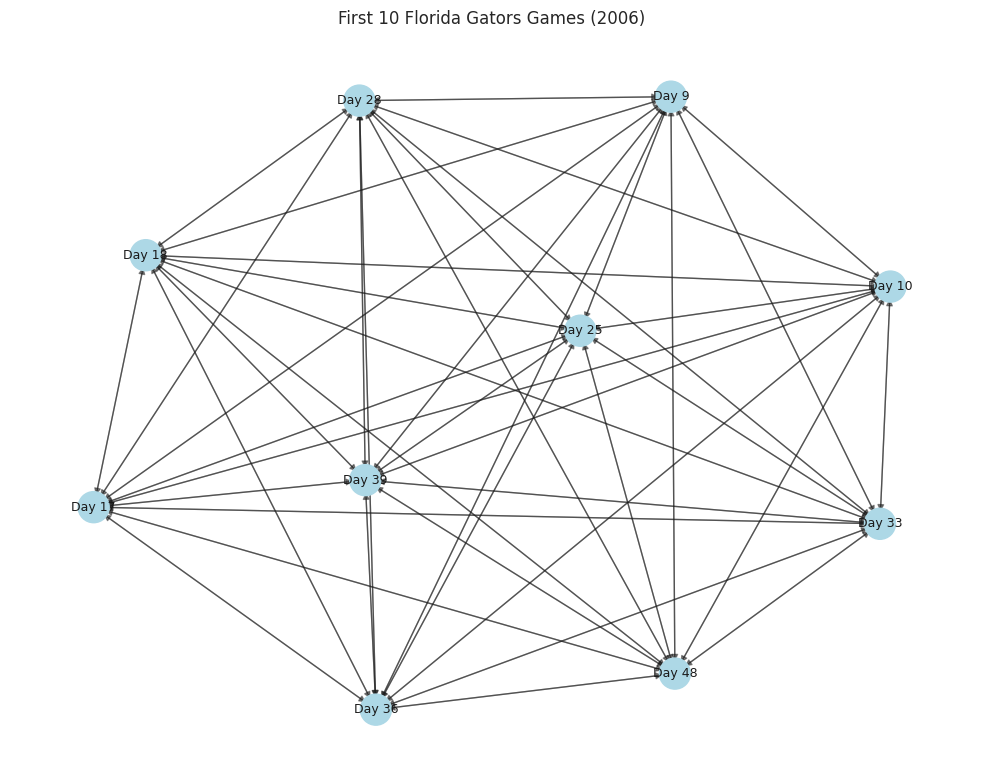


Edge types in subgraph:
Counter({np.int32(7): 44, np.int32(6): 19, np.int32(4): 19, np.int32(5): 8})


In [86]:
# Create a small subgraph for visualization
def create_florida_subgraph(season=2006, max_games=10):
    florida_season = florida_games[florida_games["Season"] == season].iloc[:max_games]
    florida_indexes = florida_season["Index"].tolist()

    # Get relevant edges (only between these games)
    subgraph_edges = edges[
        (edges["SourceIndex"].isin(florida_indexes)) &
        (edges["TargetIndex"].isin(florida_indexes))
    ]

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes (games)
    for idx, row in florida_season.iterrows():
        G.add_node(row["Index"],
                   label=f"{row['Le_TeamName']} vs {row['Ri_TeamName']}",
                   daynum=row["DayNum"],
                   tourney=row["NCAATourney"])

    # Add edges
    for idx, row in subgraph_edges.iterrows():
        G.add_edge(row["SourceIndex"], row["TargetIndex"],
                   type=row["Type"], delta=row["Delta"])

    return G, florida_season

G, florida_data = create_florida_subgraph(season=2006, max_games=10)

# Visualize the subgraph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

# Color nodes by type
node_colors = ["lightblue" if G.nodes[n]["tourney"] == 0 else "salmon" for n in G.nodes]

# Draw the network
nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors)
nx.draw_networkx_edges(G, pos, width=1, alpha=0.5)

# Add labels - just show DayNum for simplicity
labels = {n: f"Day {G.nodes[n]['daynum']}" for n in G.nodes}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

plt.title("First 10 Florida Gators Games (2006)")
plt.axis('off')
plt.tight_layout()
plt.show()

# Count edge types in this subgraph
edge_types_in_subgraph = [G.edges[e]["type"] for e in G.edges]
print("\nEdge types in subgraph:")
import collections
print(collections.Counter(edge_types_in_subgraph))

In [87]:
# Check that the indexes in both node files match
same_indexes = (nodes_asc["Index"].values == nodes_des["Index"].values).all()
print(f"Nodes have identical indexes: {same_indexes}")

# Check a few random edges against both node files
random_edges = edges.sample(5)
print("\nRandom edges sample:")
print(random_edges)

# Verify these edges in both node files
for i, edge in random_edges.iterrows():
    source_asc = nodes_asc[nodes_asc["Index"] == edge["SourceIndex"]]
    source_des = nodes_des[nodes_des["Index"] == edge["SourceIndex"]]
    target_asc = nodes_asc[nodes_asc["Index"] == edge["TargetIndex"]]
    target_des = nodes_des[nodes_des["Index"] == edge["TargetIndex"]]

    print(f"\nSource Node {edge['SourceIndex']}:")
    print(f"- ASC: {source_asc['Le_TeamName'].values[0]} vs {source_asc['Ri_TeamName'].values[0]}")
    print(f"- DES: {source_des['Le_TeamName'].values[0]} vs {source_des['Ri_TeamName'].values[0]}")

    print(f"Target Node {edge['TargetIndex']}:")
    print(f"- ASC: {target_asc['Le_TeamName'].values[0]} vs {target_asc['Ri_TeamName'].values[0]}")
    print(f"- DES: {target_des['Le_TeamName'].values[0]} vs {target_des['Ri_TeamName'].values[0]}")

Nodes have identical indexes: True

Random edges sample:
           SourceIndex  SourceSeason  SourceNCAATourney  TargetIndex  TargetSeason  TargetNCAATourney  Type  Direction  Delta
96669924        105251          2016                  0       103593          2016                  0     5         -1     19
154095825       171262          2023                  0       172415          2023                  0     7          1     13
147974405       164311          2022                  0       159564          2022                  0     4         -1     67
28993008         33423          2009                  0        29611          2009                  0     6         -1     88
110535149       119889          2018                  0       120478          2018                  0     7          1      6

Source Node 105251:
- ASC: Bucknell vs Holy Cross
- DES: Holy Cross vs Bucknell
Target Node 103593:
- ASC: Boston Univ vs Loyola MD
- DES: Loyola MD vs Boston Univ

Source Node 171262:
-

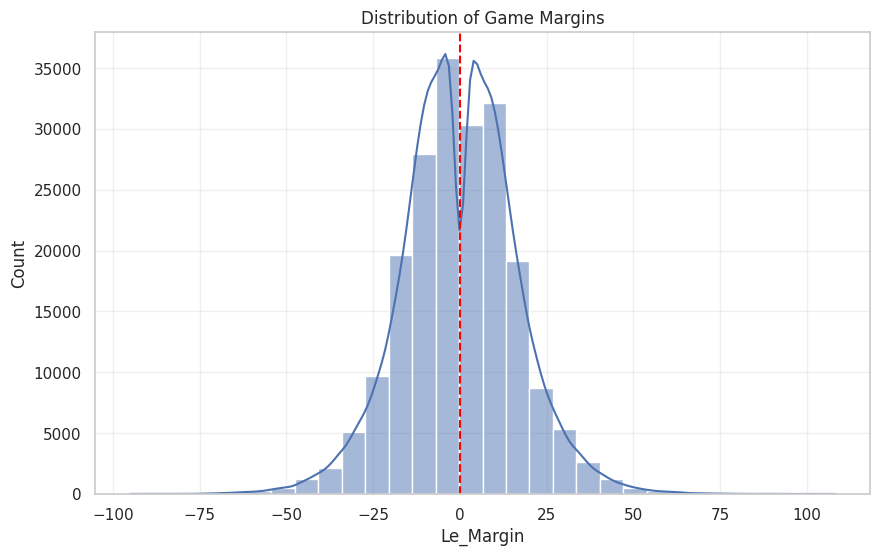

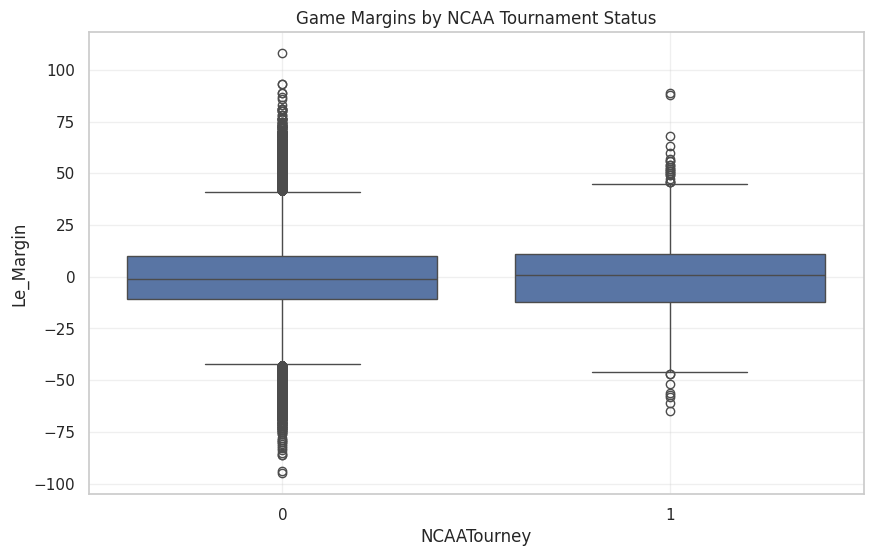

Number of NCAA Tournament games (2021-2024): 531
Mean margin in test games: 0.24
Std dev of margin in test games: 18.00


In [89]:
# Distribution of game margins
plt.figure(figsize=(10, 6))
sns.histplot(nodes_asc["Le_Margin"], bins=30, kde=True)
plt.title("Distribution of Game Margins")
plt.axvline(x=0, color='red', linestyle='--')
plt.grid(True, alpha=0.3)
plt.show()

# Distribution of margins by NCAA Tournament status
plt.figure(figsize=(10, 6))
sns.boxplot(x="NCAATourney", y="Le_Margin", data=nodes_asc)
plt.title("Game Margins by NCAA Tournament Status")
plt.grid(True, alpha=0.3)
plt.show()

# Calculate stats for NCAA Tournament games for 2021-2024 (test set)
test_games = nodes_asc[(nodes_asc["Season"].between(2021, 2024)) & (nodes_asc["NCAATourney"] == 1)]
print(f"Number of NCAA Tournament games (2021-2024): {len(test_games)}")
print(f"Mean margin in test games: {test_games['Le_Margin'].mean():.2f}")
print(f"Std dev of margin in test games: {test_games['Le_Margin'].std():.2f}")

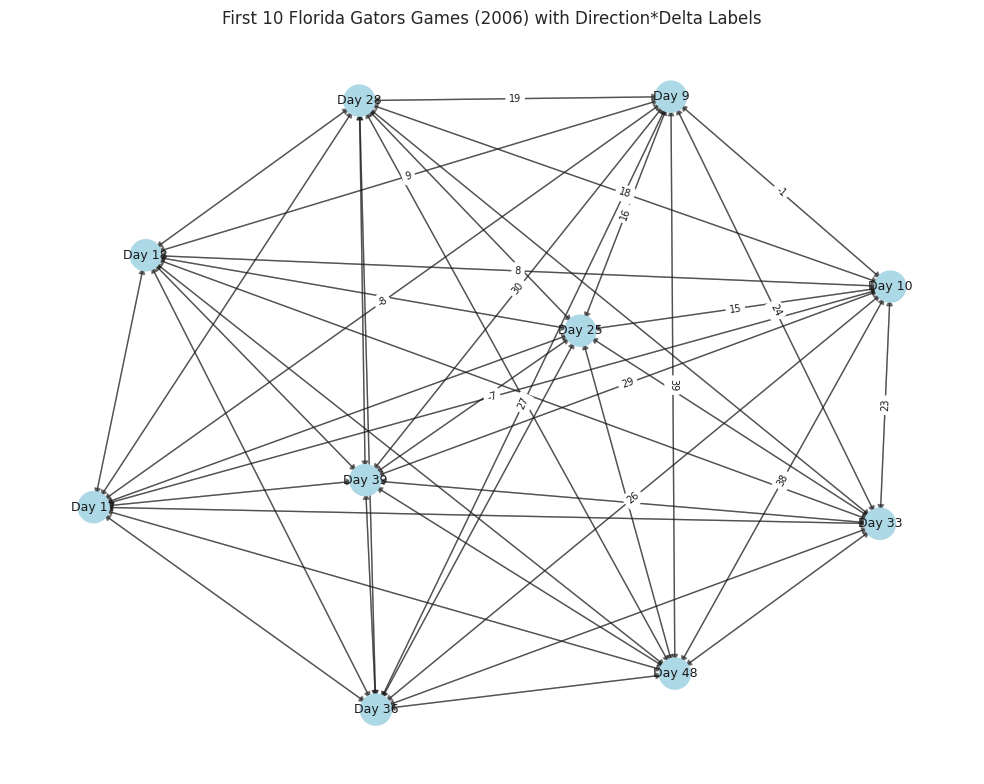


Edge types with Direction*Delta range:
Type 6: 19 edges, Dir*Delta range: [-38 to 30]
Type 7: 44 edges, Dir*Delta range: [-39 to 39]
Type 4: 19 edges, Dir*Delta range: [-30 to 38]
Type 5: 8 edges, Dir*Delta range: [-29 to 29]


In [91]:
# Create a Florida subgraph with Direction * Delta edge labels
def create_florida_subgraph(season=2006, max_games=10):
    florida_season = florida_games[florida_games["Season"] == season].iloc[:max_games]
    florida_indexes = florida_season["Index"].tolist()

    # Get relevant edges (only between these games)
    subgraph_edges = edges[
        (edges["SourceIndex"].isin(florida_indexes)) &
        (edges["TargetIndex"].isin(florida_indexes))
    ]

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes (games)
    for idx, row in florida_season.iterrows():
        G.add_node(row["Index"],
                   label=f"{row['Le_TeamName']} vs {row['Ri_TeamName']}",
                   daynum=row["DayNum"],
                   tourney=row["NCAATourney"])

    # Add edges with Direction * Delta as an attribute
    for idx, row in subgraph_edges.iterrows():
        dir_delta = row["Direction"] * row["Delta"]
        G.add_edge(row["SourceIndex"], row["TargetIndex"],
                   type=row["Type"], dir_delta=dir_delta)

    return G, florida_season

G, florida_data = create_florida_subgraph(season=2006, max_games=10)

# Visualize the subgraph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

# Color nodes by type
node_colors = ["lightblue" if G.nodes[n]["tourney"] == 0 else "salmon" for n in G.nodes]

# Draw the network
nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors)
nx.draw_networkx_edges(G, pos, width=1, alpha=0.5)

# Add labels - just show DayNum for simplicity
labels = {n: f"Day {G.nodes[n]['daynum']}" for n in G.nodes}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

# Add edge labels (Direction * Delta)
edge_labels = {(u, v): f"{G.edges[u, v]['dir_delta']}" for u, v in G.edges}
# Only show a subset of labels to avoid overcrowding
sample_edges = list(G.edges())[:20]  # Just show first 20 edge labels
sample_edge_labels = {e: edge_labels[e] for e in sample_edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=sample_edge_labels, font_size=7)

plt.title("First 10 Florida Gators Games (2006) with Direction*Delta Labels")
plt.axis('off')
plt.tight_layout()
plt.show()

# Count edge types and their direction*delta values in this subgraph
edge_types = {}
for u, v, data in G.edges(data=True):
    edge_type = data["type"]
    dir_delta = data["dir_delta"]
    if edge_type not in edge_types:
        edge_types[edge_type] = []
    edge_types[edge_type].append(dir_delta)

print("\nEdge types with Direction*Delta range:")
for t, values in edge_types.items():
    print(f"Type {t}: {len(values)} edges, Dir*Delta range: [{min(values)} to {max(values)}]")

In [95]:
print(nodes_asc.sort_values("Le_Margin").iloc[[0]])

         Index                 Key  Season       Date  Le_TeamID  Ri_TeamID  Le_TeamName Ri_TeamName  Le_Margin  SeasonsAgo  Men  NCAATourney  DayNum  NumOT  Le_Loc  Le_Score  Le_FGM  Le_FGA  Le_FGM3  Le_FGA3  Le_FTM  Le_FTA  Le_OR  Le_DR  Le_Ast  Le_TO  Le_Stl  Le_Blk  Le_PF  Ri_Score  Ri_FGM  Ri_FGA  Ri_FGM3  Ri_FGA3  Ri_FTM  Ri_FTA  Ri_OR  Ri_DR  Ri_Ast  Ri_TO  Ri_Stl  Ri_Blk  Ri_PF
159178  159178  2022_008_3309_3400    2022 2021-11-09       3309       3400  New Orleans       Texas        -95           3    0            0       8      0      -1        36      12      49        5       21       7      10      6     13       8     37       4       1     33       131      47      77       13       23      24      43     19     28      30     12      17       3     17


[Texas Women's 2021-22 schedule and results](https://texaslonghorns.com/sports/womens-basketball/schedule/2021-22)

vs. New Orleans 131-36

In [97]:
print(nodes_asc[nodes_asc["NCAATourney"] == 1].sort_values("Le_Margin").iloc[[0]])

       Index                 Key  Season       Date  Le_TeamID  Ri_TeamID Le_TeamName Ri_TeamName  Le_Margin  SeasonsAgo  Men  NCAATourney  DayNum  NumOT  Le_Loc  Le_Score  Le_FGM  Le_FGA  Le_FGM3  Le_FGA3  Le_FTM  Le_FTA  Le_OR  Le_DR  Le_Ast  Le_TO  Le_Stl  Le_Blk  Le_PF  Ri_Score  Ri_FGM  Ri_FGA  Ri_FGM3  Ri_FGA3  Ri_FTM  Ri_FTA  Ri_OR  Ri_DR  Ri_Ast  Ri_TO  Ri_Stl  Ri_Blk  Ri_PF
55338  55338  2011_138_3391_3397    2011 2011-03-19       3391       3397     Stetson   Tennessee        -65          14    0            1     138      0      -1        34      12      66        3       24       7       9     10     21       3     13       3       1     18        99      39      70        8       20      13      24     17     46      19      7       7       9     10


  [2011 Women's NCAA Tourney](https://en.wikipedia.org/wiki/2011_NCAA_Division_I_women%27s_basketball_tournament#Dayton_Region)

1 Tennessee vs 16 Stetson: 99-34

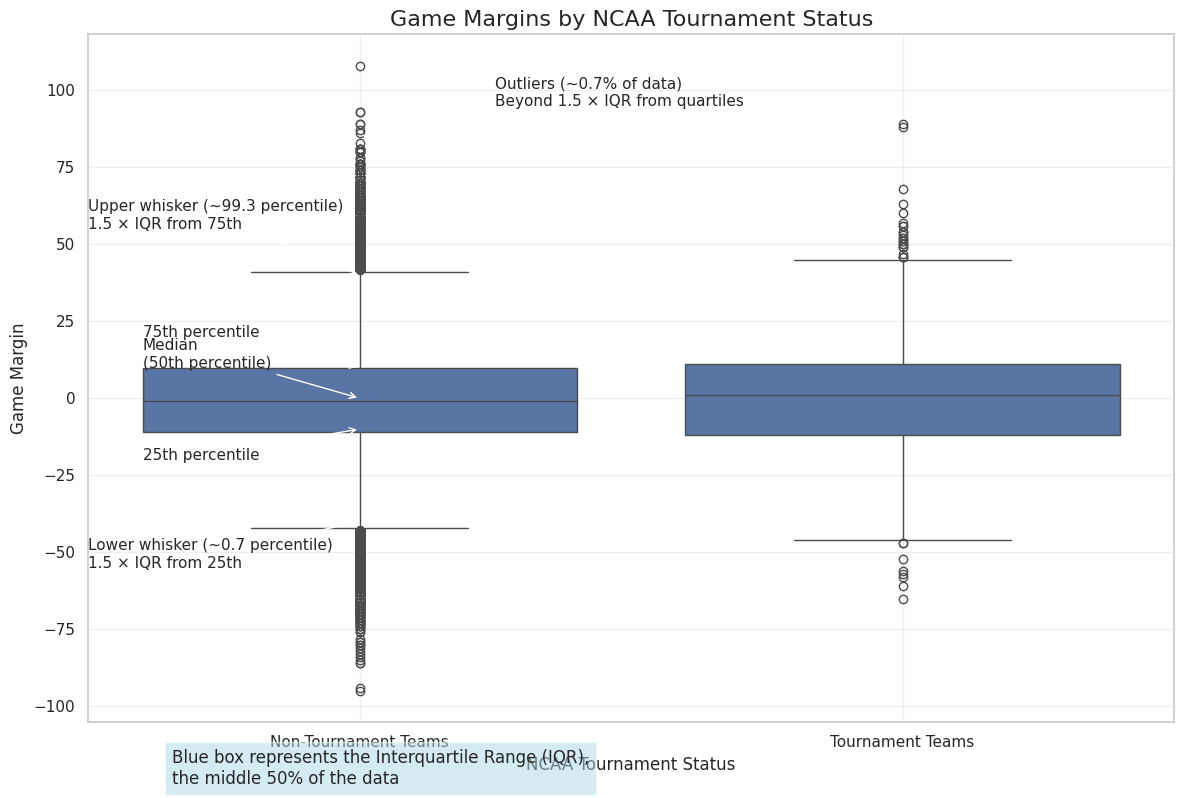

In [100]:
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x="NCAATourney", y="Le_Margin", data=nodes_asc)
plt.title("Game Margins by NCAA Tournament Status", fontsize=16)
plt.grid(True, alpha=0.3)

# Add annotations for key components - focusing on the first box (index 0)
# Hardcoding positions for annotations instead of trying to extract them from artists

# Median line annotation
plt.annotate('Median\n(50th percentile)',
             xy=(0, 0),  # Approximate median position
             xytext=(-0.4, 10),
             arrowprops=dict(arrowstyle='->'),
             fontsize=11)

# 75th percentile (top of box)
plt.annotate('75th percentile',
             xy=(0, 10),  # Approximate top of box
             xytext=(-0.4, 20),
             arrowprops=dict(arrowstyle='->'),
             fontsize=11)

# 25th percentile (bottom of box)
plt.annotate('25th percentile',
             xy=(0, -10),  # Approximate bottom of box
             xytext=(-0.4, -20),
             arrowprops=dict(arrowstyle='->'),
             fontsize=11)

# Upper whisker
plt.annotate('Upper whisker (~99.3 percentile)\n1.5 × IQR from 75th',
             xy=(0, 40),  # Approximate whisker position
             xytext=(-0.5, 55),
             arrowprops=dict(arrowstyle='->'),
             fontsize=11)

# Lower whisker
plt.annotate('Lower whisker (~0.7 percentile)\n1.5 × IQR from 25th',
             xy=(0, -40),  # Approximate whisker position
             xytext=(-0.5, -55),
             arrowprops=dict(arrowstyle='->'),
             fontsize=11)

# Outliers
plt.annotate('Outliers (~0.7% of data)\nBeyond 1.5 × IQR from quartiles',
             xy=(0, 85),
             xytext=(0.25, 95),
             arrowprops=dict(arrowstyle='->'),
             fontsize=11)

# Add legend for box meaning
plt.figtext(0.15, 0.01, "Blue box represents the Interquartile Range (IQR),\nthe middle 50% of the data",
            ha="left", fontsize=12, bbox={"facecolor":"lightblue", "alpha":0.5, "pad":5})

# Better x-axis labels
plt.xticks([0, 1], ['Non-Tournament Teams', 'Tournament Teams'])
plt.xlabel("NCAA Tournament Status", fontsize=12)
plt.ylabel("Game Margin", fontsize=12)

plt.tight_layout()
plt.show()

In [120]:
# Function to create visualization for a specific edge type
def visualize_edge_type(edges_df, edge_type, source_node=17126):
    # Filter edges by source node and edge type
    filtered_edges = edges_df[(edges_df['SourceIndex'] == source_node) &
                              (edges_df['Type'] == edge_type)]

    if filtered_edges.empty:
        print(f"No edges of type {edge_type} from node {source_node}")
        return

    # Create graph
    G = nx.DiGraph()

    # Add source node
    source_row = nodes_asc[nodes_asc['Index'] == source_node].iloc[0]
    G.add_node(source_node,
               label=f"{source_row['Le_TeamName']} vs {source_row['Ri_TeamName']}\n{source_row['Le_Score']}-{source_row['Ri_Score']}",
               pos_x=0,
               pos_y=0)

    # Add target nodes and edges
    for idx, edge in filtered_edges.iterrows():
        target_node = edge['TargetIndex']
        if target_node == source_node:
            continue

        target_row = nodes_asc[nodes_asc['Index'] == target_node].iloc[0]

        # Position based on Direction * Delta
        pos_x = edge['Direction'] * edge['Delta']
        pos_y = (idx % 5 - 2) * 0.8 + np.random.uniform(-0.3, 0.3)

        G.add_node(target_node,
                   label=f"{target_row['Le_TeamName']} vs {target_row['Ri_TeamName']}\n{target_row['Le_Score']}-{target_row['Ri_Score']}",
                   pos_x=pos_x,
                   pos_y=pos_y)

        G.add_edge(source_node, target_node,
                   weight=edge['Direction'] * edge['Delta'],
                   delta=edge['Delta'],
                   direction=edge['Direction'])

    plt.figure(figsize=(20, 14))

    # Create position dictionary
    pos = {node: (G.nodes[node]['pos_x'], G.nodes[node]['pos_y']) for node in G.nodes()}

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue')

    # Draw edges with color based on direction
    edge_colors = ['red' if G.edges[e]['direction'] < 0 else 'green' for e in G.edges()]
    nx.draw_networkx_edges(G, pos, arrowsize=20, width=2, edge_color=edge_colors)

    # Draw edge labels
    edge_labels = {(u, v): f"{G.edges[u, v]['direction'] * G.edges[u, v]['delta']}" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Draw node labels
    node_labels = {n: G.nodes[n]['label'] for n in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_weight='bold')

    plt.title(f"Connections from Game {source_node} (Edge Type {edge_type})")
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
    plt.xlim(-max([abs(v) for v in nx.get_node_attributes(G, 'pos_x').values()]) * 1.1,
             max([abs(v) for v in nx.get_node_attributes(G, 'pos_x').values()]) * 1.1)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

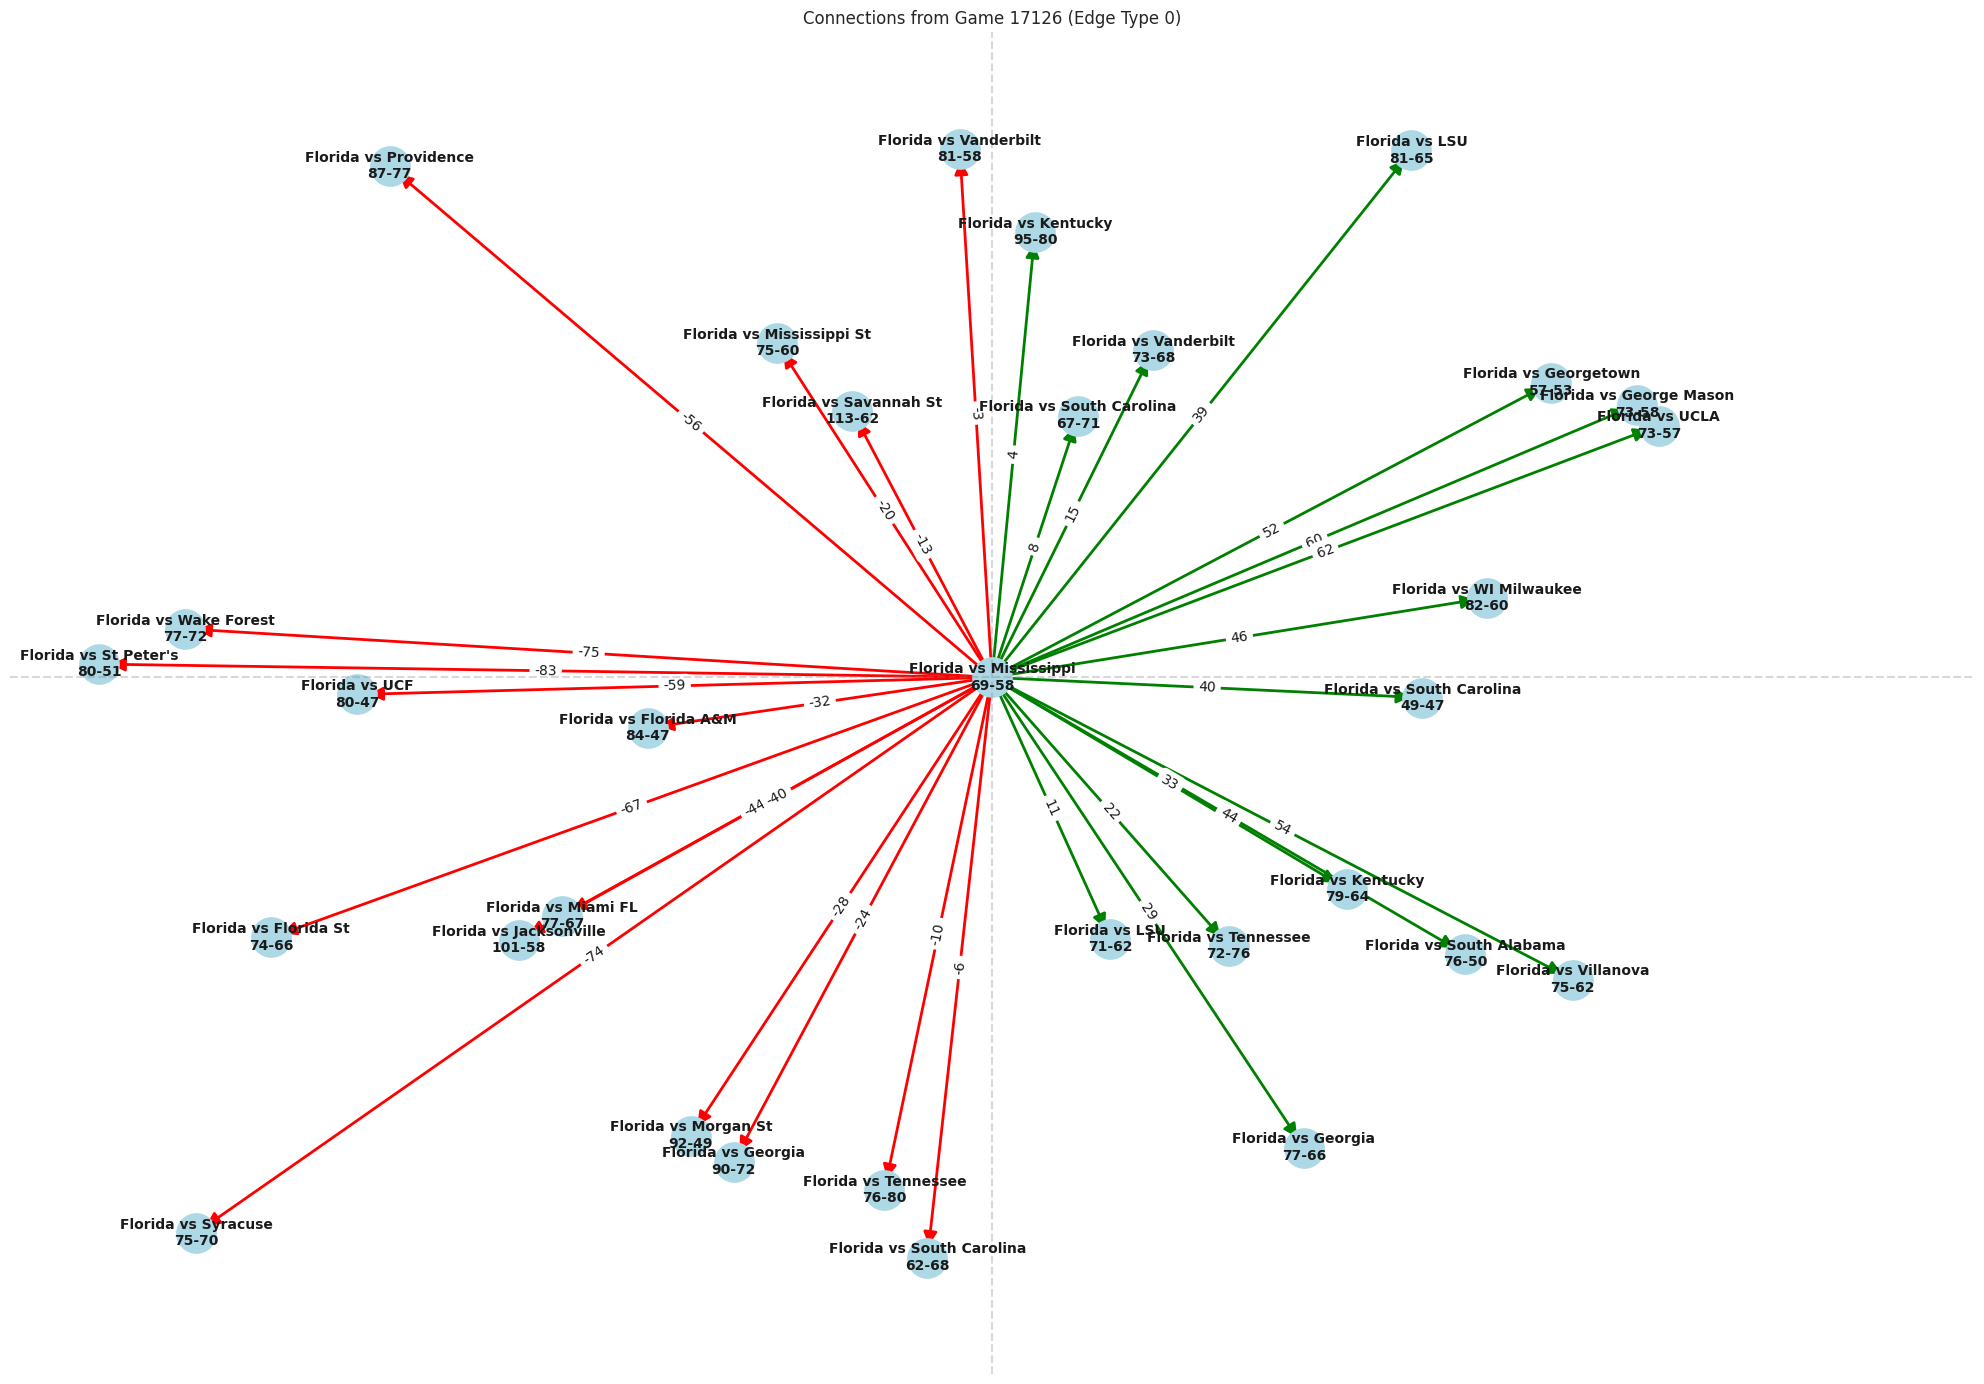

In [121]:
visualize_edge_type(edges, 0)

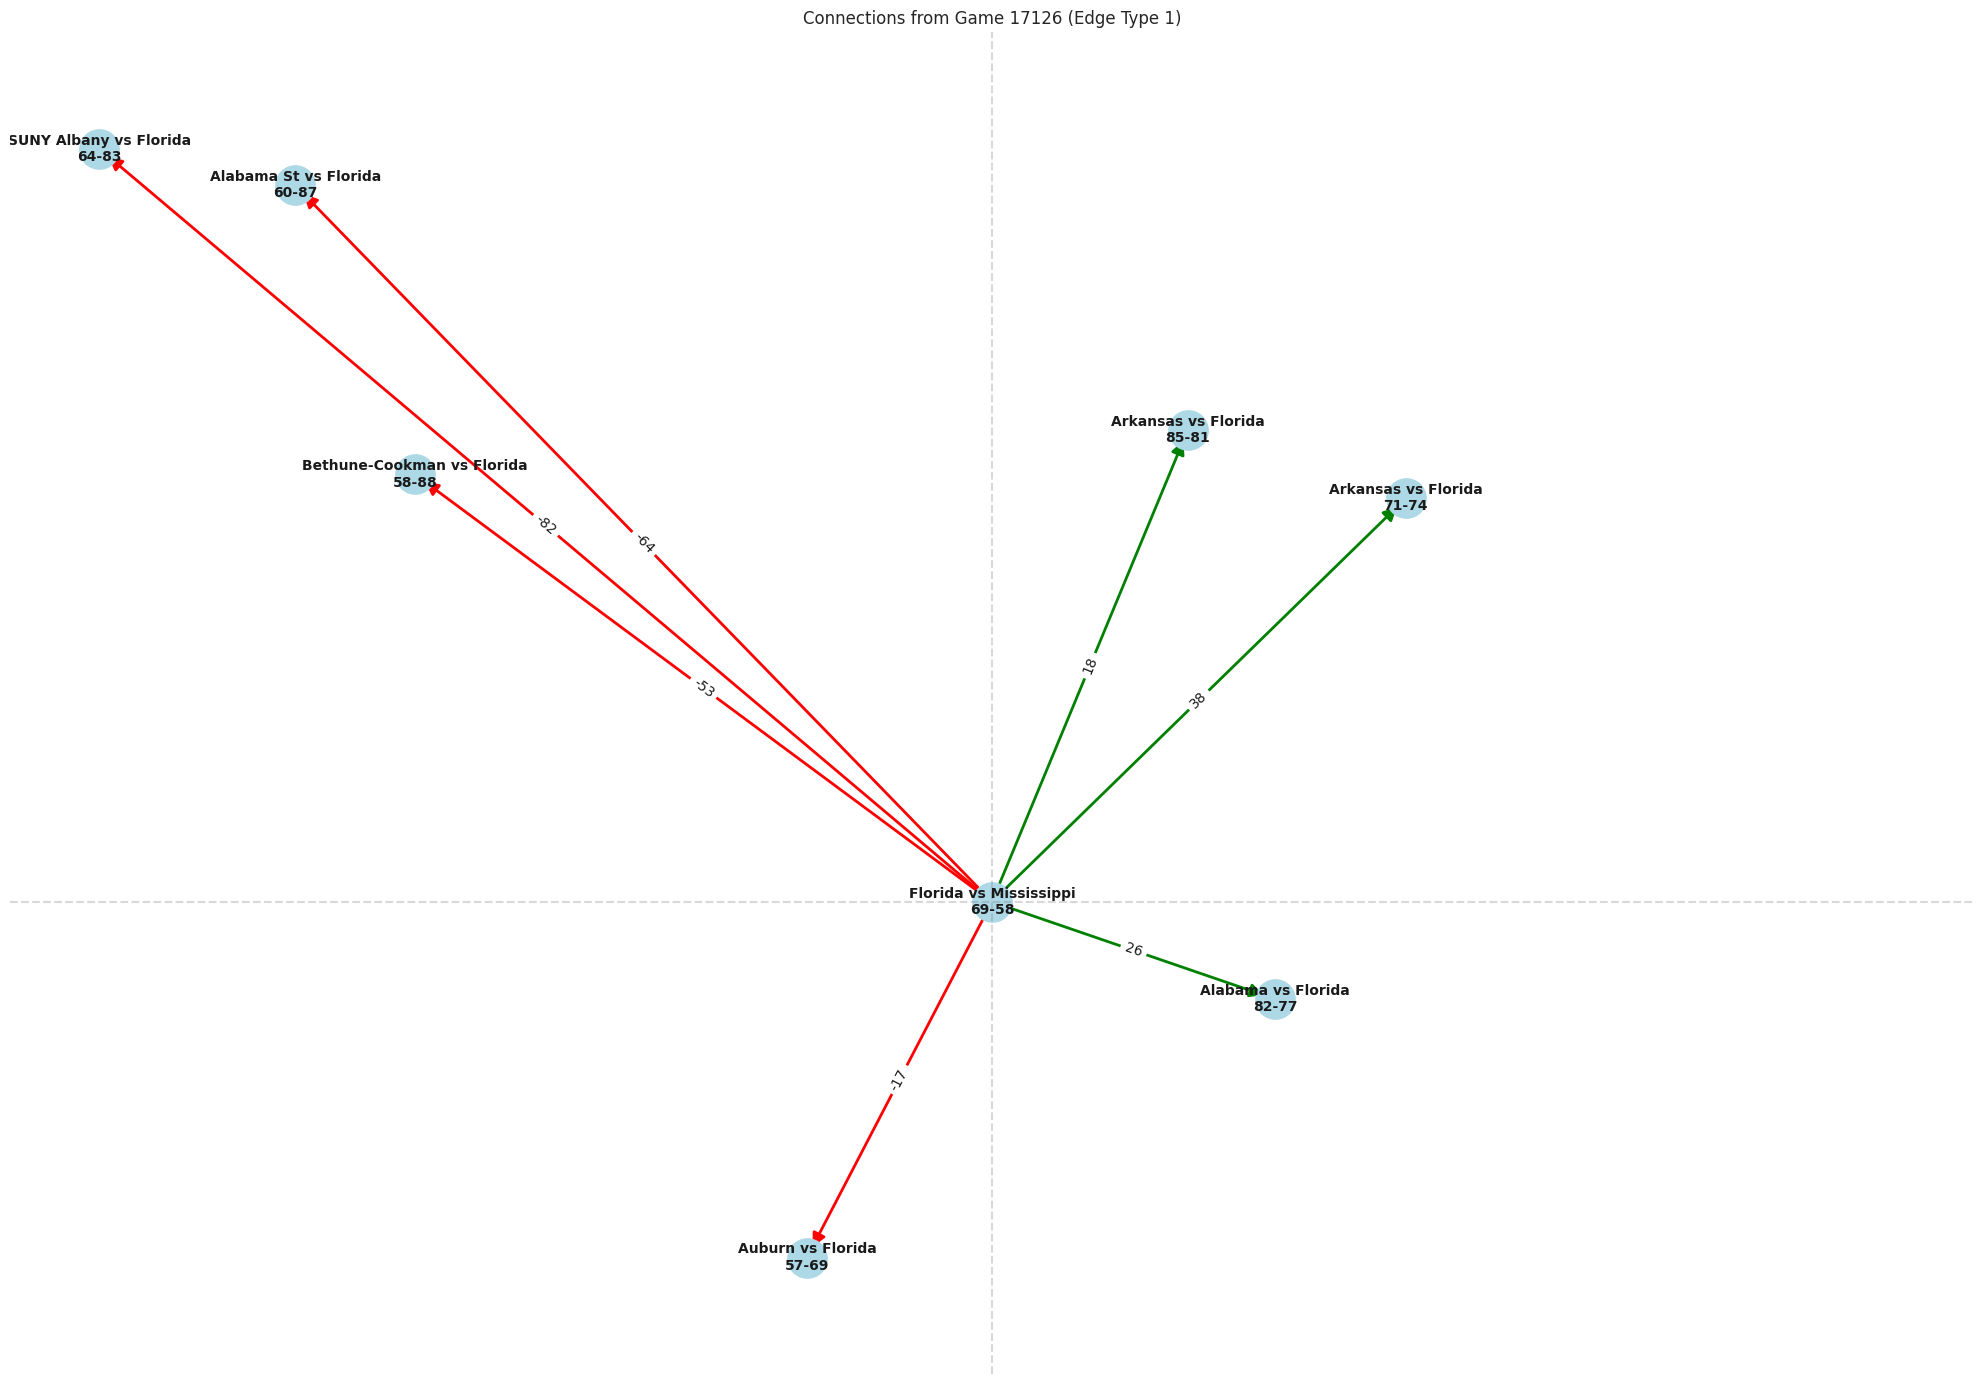

In [122]:
visualize_edge_type(edges, 1)

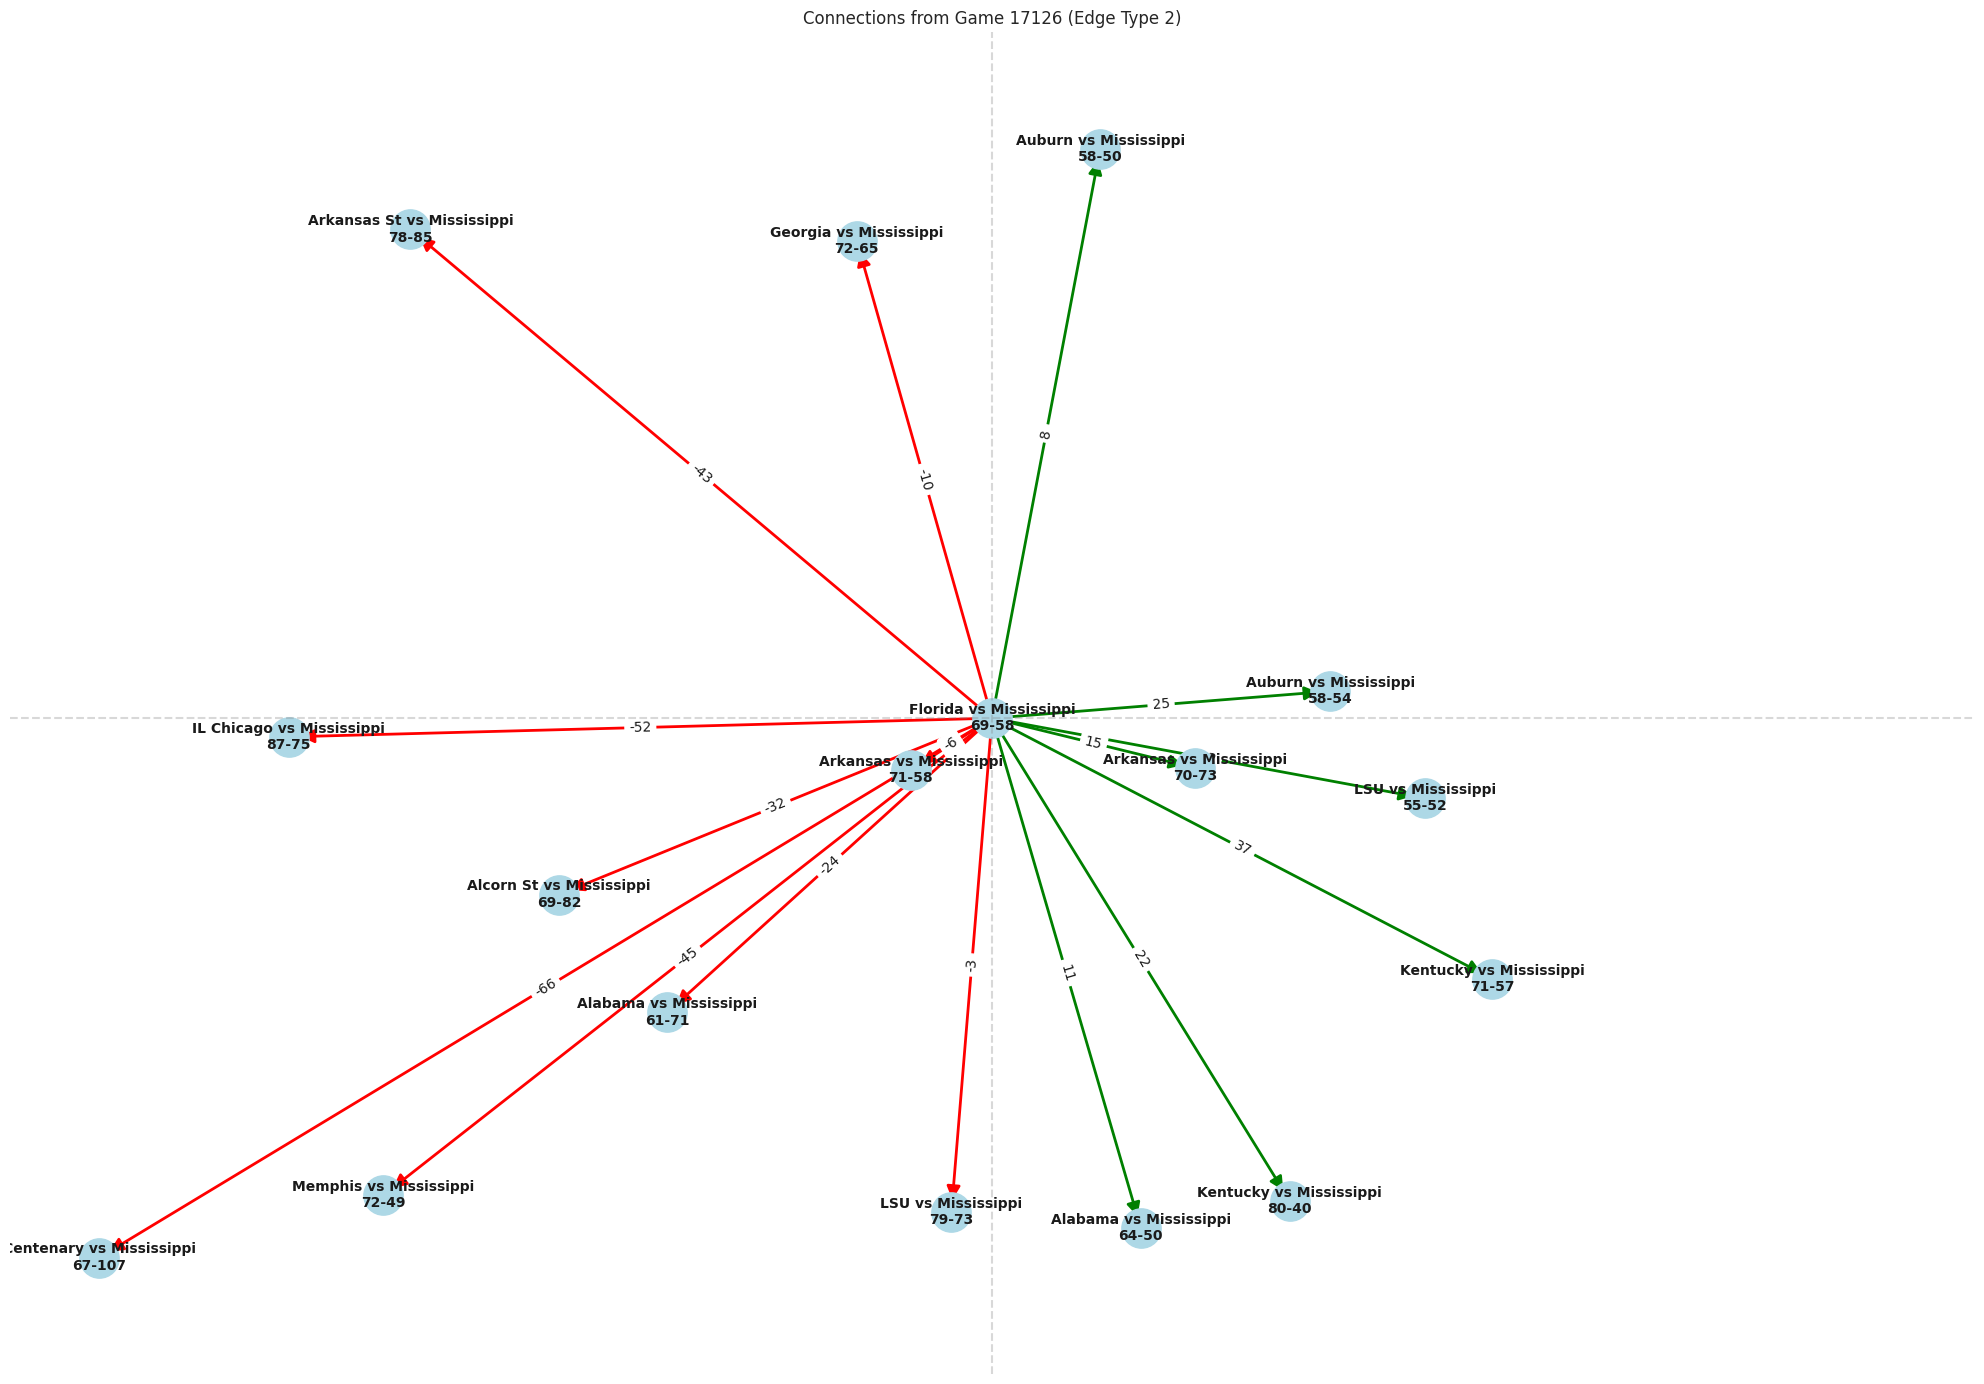

In [123]:
visualize_edge_type(edges, 2)

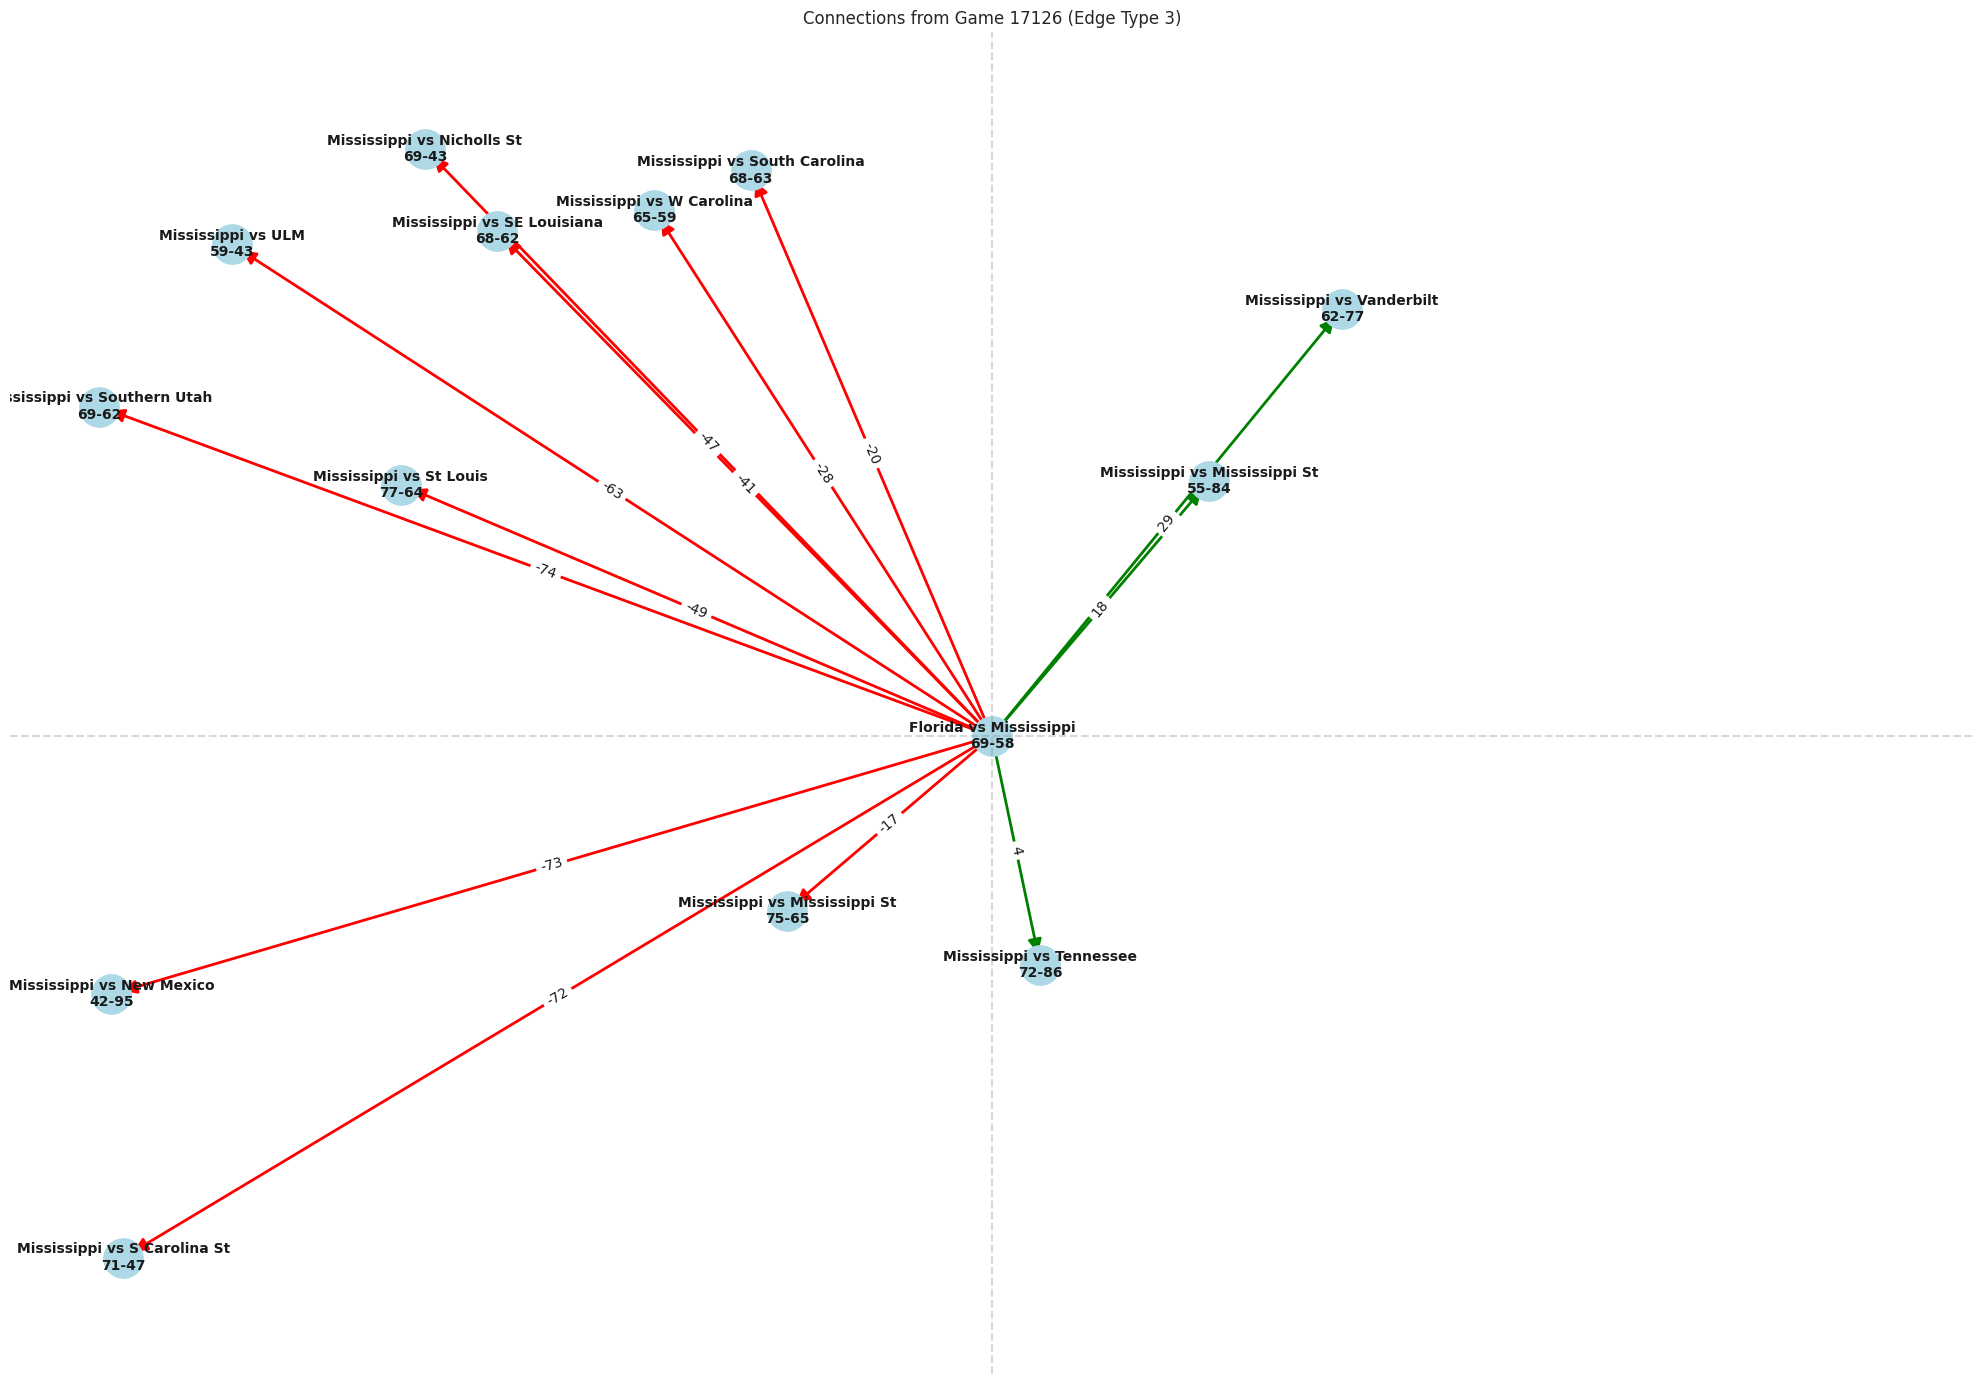

In [124]:
visualize_edge_type(edges, 3)

In [125]:
visualize_edge_type(edges, 4)

Output hidden; open in https://colab.research.google.com to view.

In [126]:
visualize_edge_type(edges, 5)

Output hidden; open in https://colab.research.google.com to view.

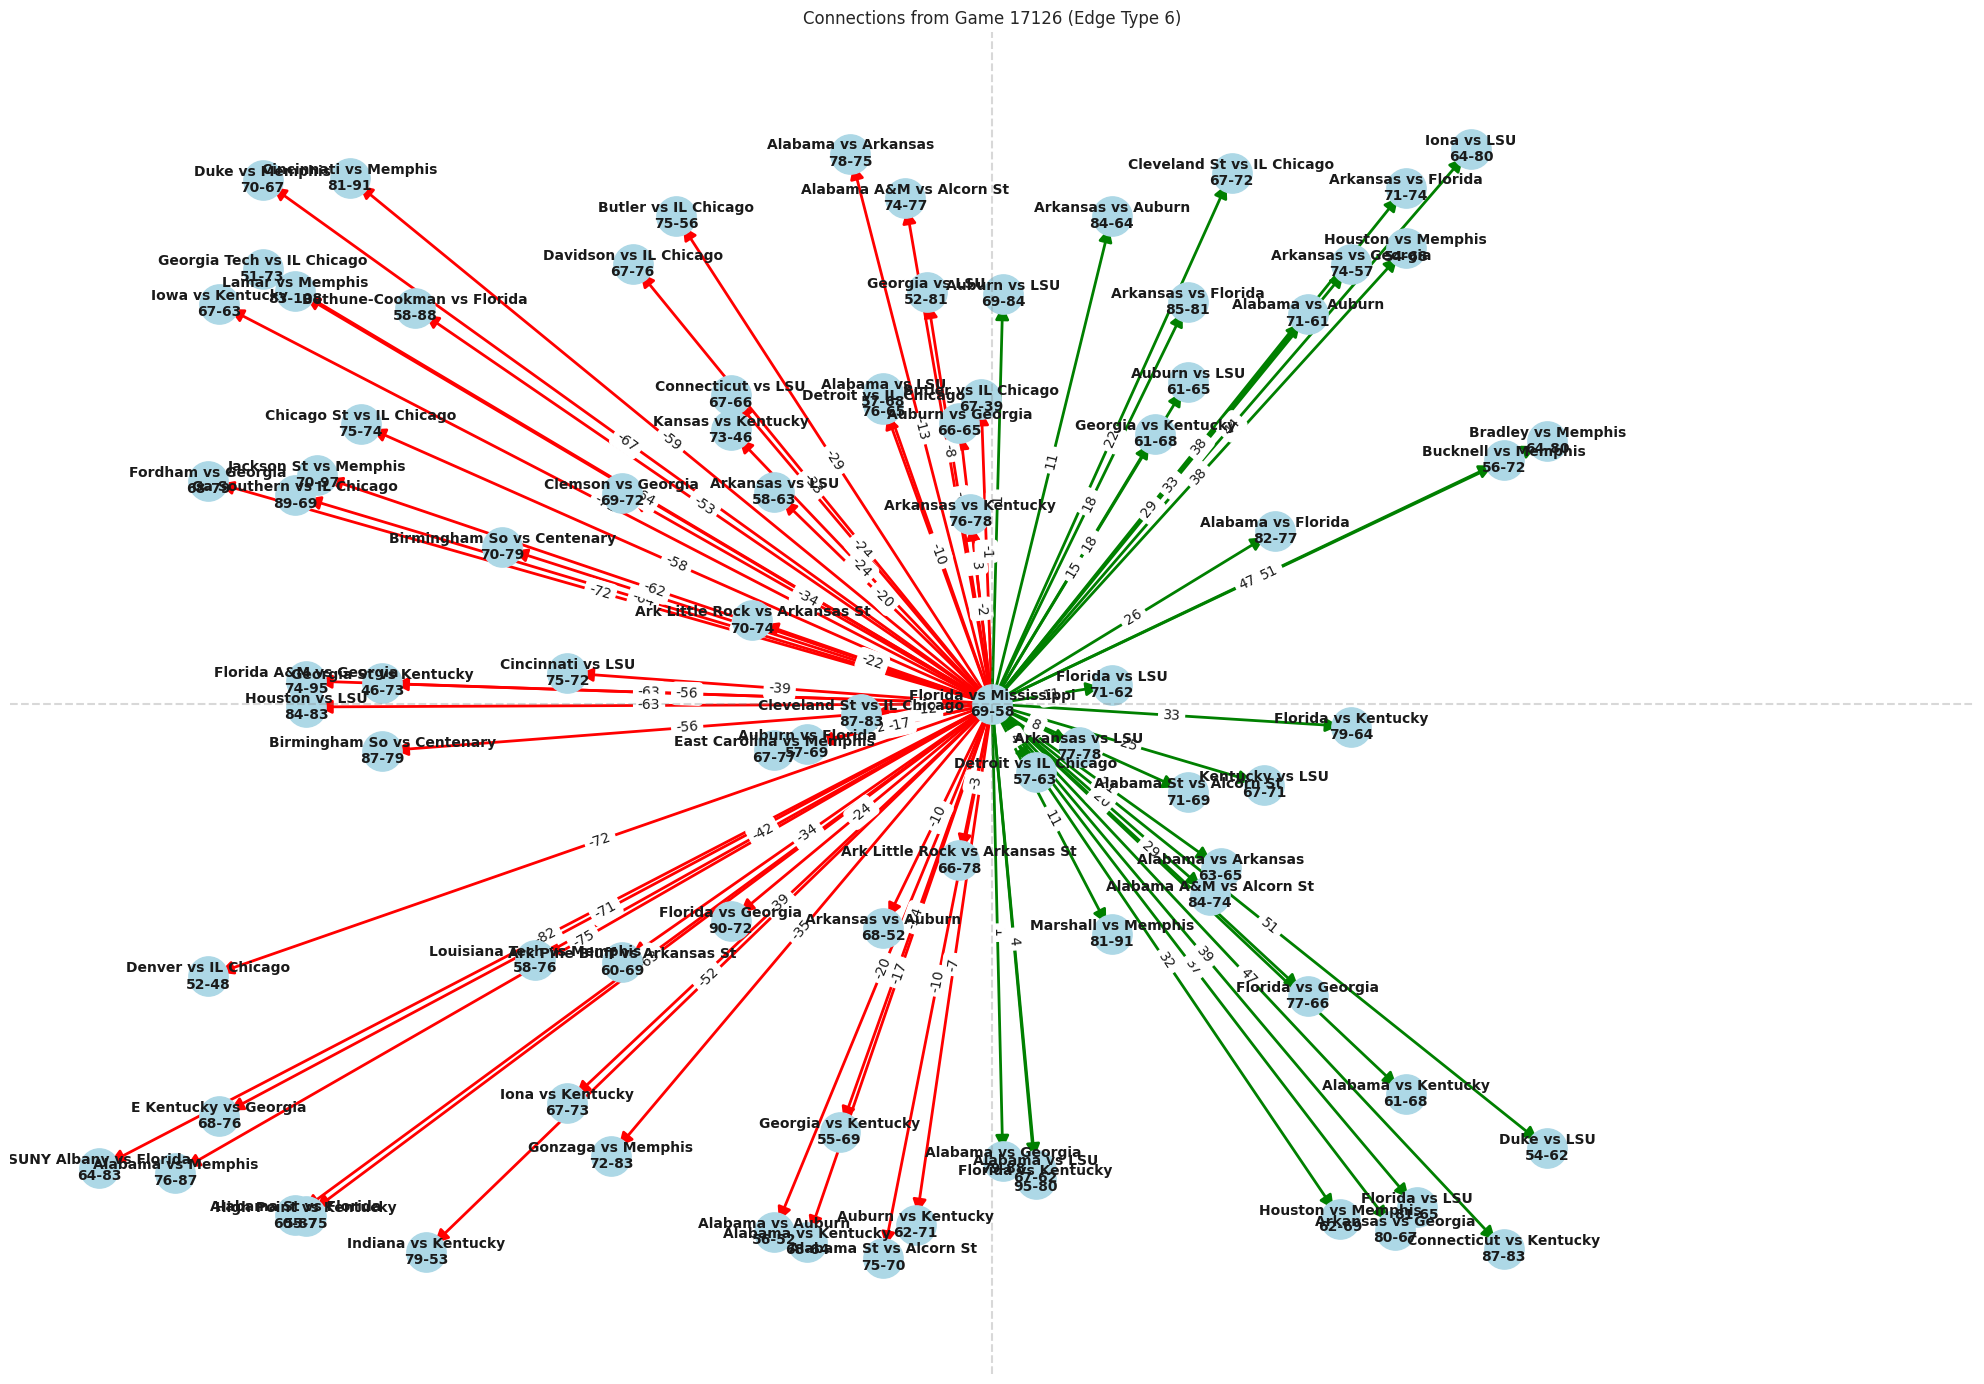

In [127]:
visualize_edge_type(edges, 6)

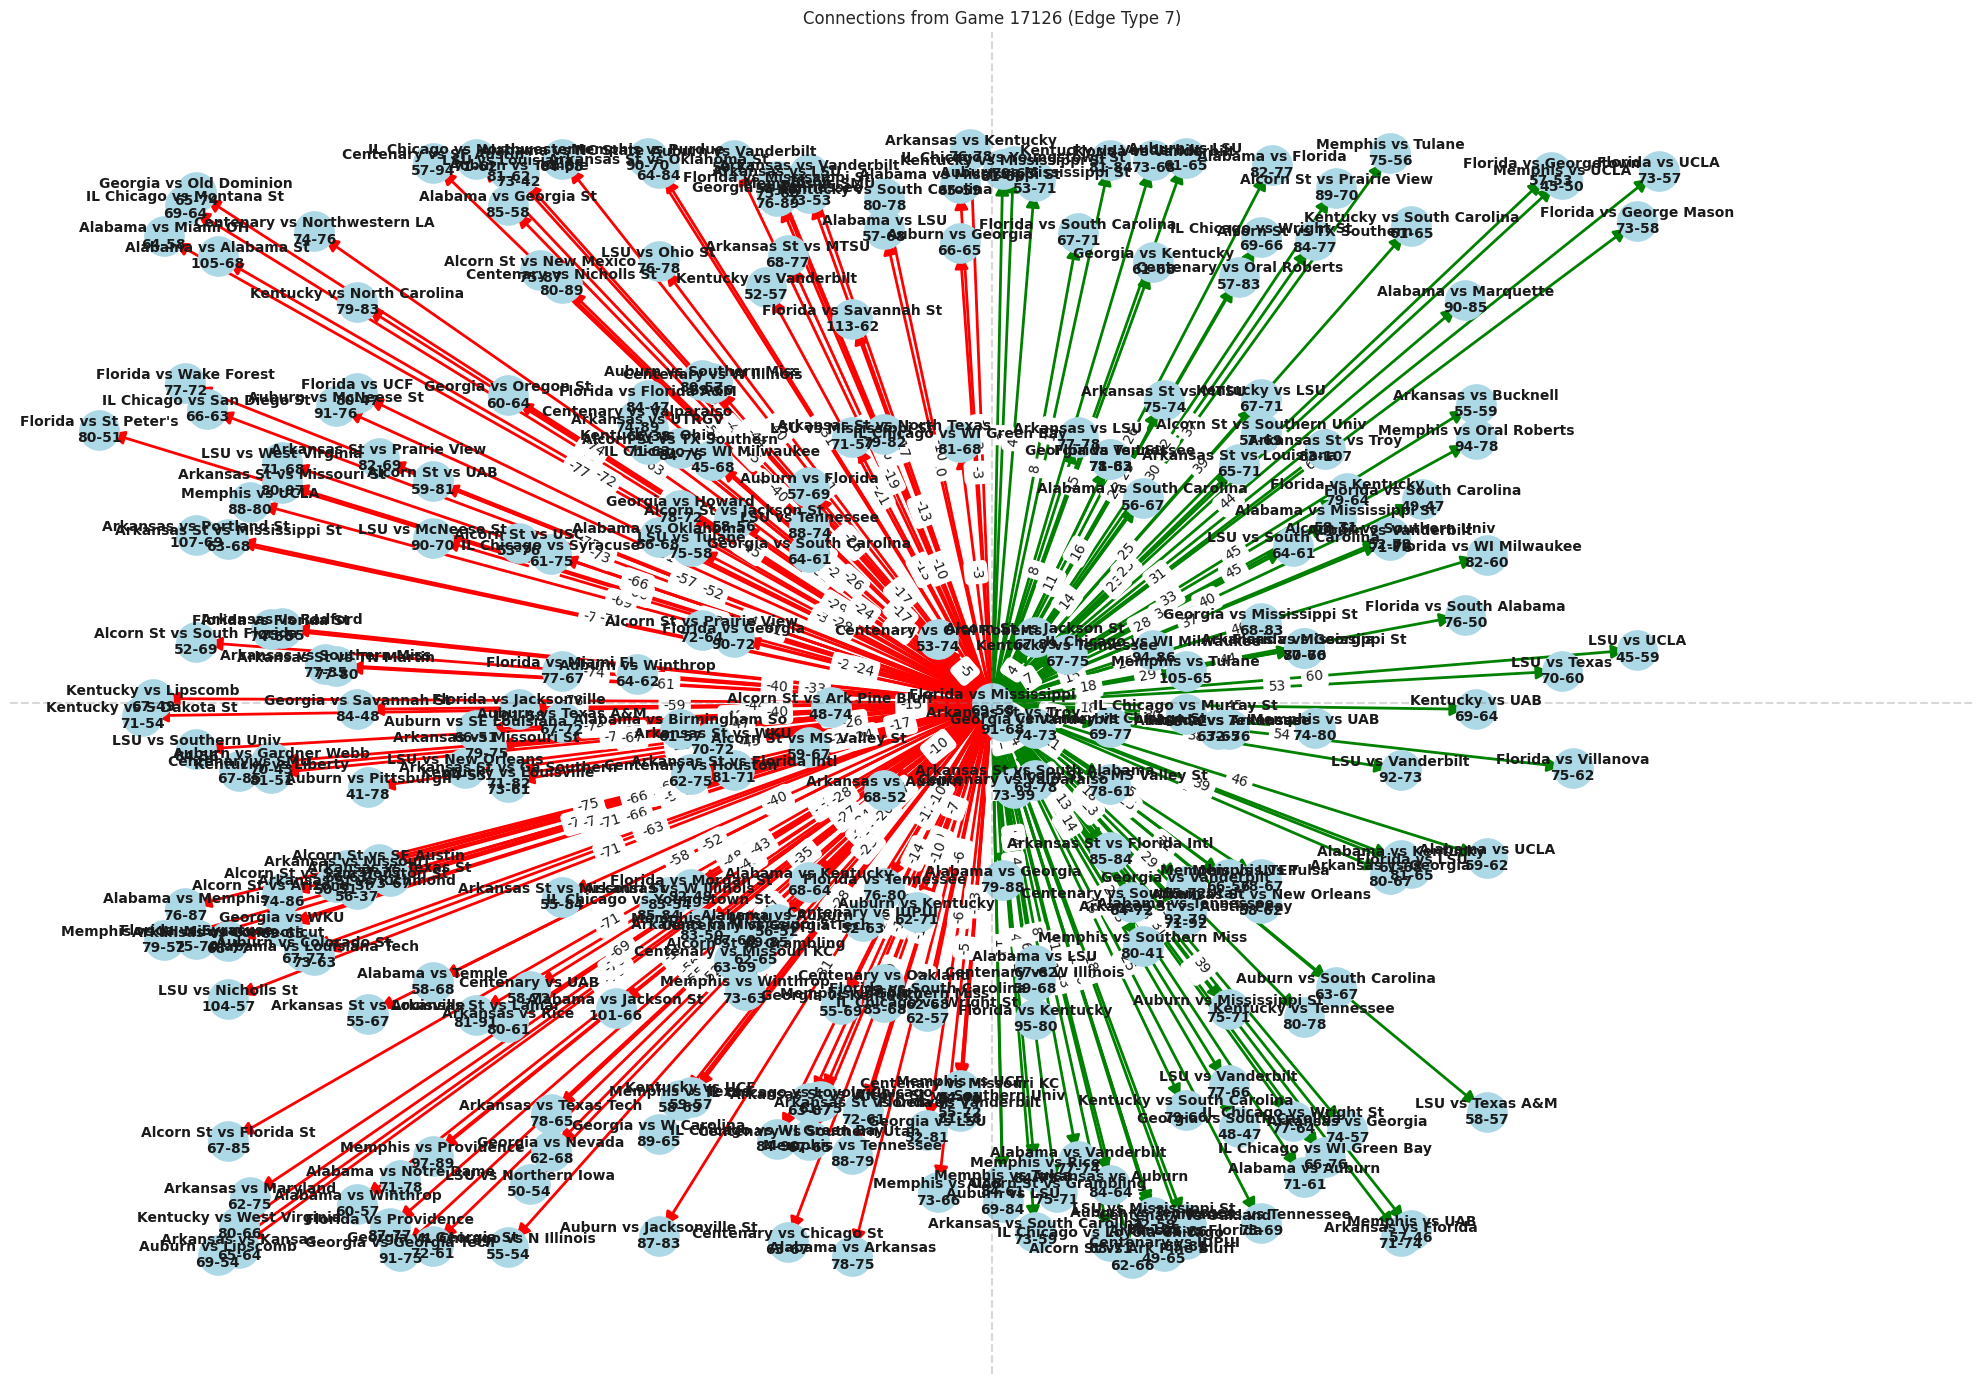

In [128]:
visualize_edge_type(edges, 7)